<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


**Технологический процесс**
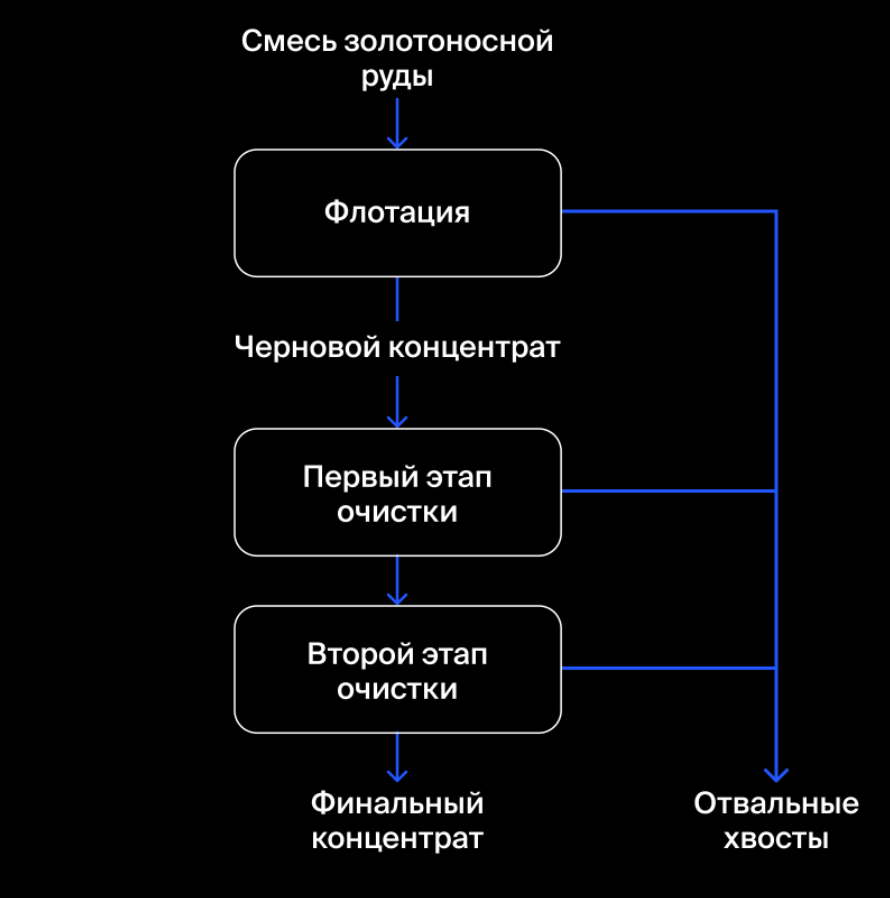

Rougher feed — исходное сырье\
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
 * Xanthate — ксантогенат (промотер, или активатор флотации);
 * Sulphate — сульфат (на данном производстве сульфид натрия);
 * Depressant — депрессант (силикат натрия).
 
Rougher process (англ. «грубый процесс») — флотация\
Rougher tails — отвальные хвосты\
Float banks — флотационная установка\
Cleaner process — очистка\
Rougher Au — черновой концентрат золота\
Final Au — финальный концентрат золота

**Параметры этапов**

air amount — объём воздуха\
fluid levels — уровень жидкости\
feed size — размер гранул сырья\
feed rate — скорость подачи

**Наименование признаков:**

rougher — флотация\
primary_cleaner — первичная очистка\
secondary_cleaner — вторичная очистка\
final — финальные характеристики

input — параметры сырья\
output — параметры продукта\
state — параметры, характеризующие текущее состояние этапа\
calculation — расчётные характеристики

**Эффективность обогащения рассчитывается по формуле**

Recovery = (C * (F - T)) / (F * (C - T))  * 100 %,

где: 
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Сохраним необходимые данные в таблицах

In [2]:
gold_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
gold_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
gold_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

Проверим общую информацию о данных в таблицах

In [3]:
gold_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
gold_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [7]:
gold_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


1) Первый столбец всех таблиц имеет формат object, хотя содержит дату и время, его можно перевести в формат datetime\
2) В таблице gold_test меньше столбцов, чем в остальных таблицах (53 вместо 87)\
3) В таблицах есть пропуски значений

**Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`**

In [9]:
def recovery(C,F,T):
    recovery = (C * (F - T)) / (F * (C - T)) * 100
    return recovery

In [10]:
rougher_recovery = recovery(gold_train['rougher.output.concentrate_au'], 
                            gold_train['rougher.input.feed_au'], 
                            gold_train['rougher.output.tail_au'])

In [11]:
rougher_recovery.head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

In [12]:
gold_train['rougher.output.recovery'].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

Найдём MAE между нашими расчётами и значением признака

In [13]:
mean_absolute_error(gold_train['rougher.output.recovery'], rougher_recovery)

9.73512347450521e-15

Значения в столбце rougher.output.recovery совпадают, что может свидетельствовать о том, что величина в столбце `rougher.output.recovery` раситывается по той же формуле, на основе данных в столбцах `rougher.output.concentrate_au`, `rougher.input.feed_au` и `rougher.output.tail_au`

**Проанализируем признаки, недоступные в тестовой выборке**

In [14]:
dif_tables = gold_full.columns.difference(gold_test.columns)
print('Cтолбцы, отсутствующие в тестовой выборке:','\n', dif_tables)
print('Количество столбцов, отсутствующих в тестовой выборке:', len(dif_tables))

Cтолбцы, отсутствующие в тестовой выборке: 
 Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'ro

1) В тестовой выборке отсутствуют значения параметров продукта (выходные значения) для всех этапов технологического процесса (флотация, первичная очистка, вторичная очистка, финальные характеристики).

2) В тестовой выборке нет параметров `feed`, необходимых для проверки размеров гранул сырья.

Дополним тестовую выборку недостающими столбцами из полной выборки

In [15]:
gold_test = gold_test.merge(gold_full, how = 'left')
gold_test.shape

(5290, 87)

**Проверим долю пропущенных значений от общего количества значений в процентах**

In [16]:
gold_full.isna().mean().sort_values(ascending=False).head(20)*100

secondary_cleaner.output.tail_sol           8.992232
rougher.input.floatbank11_xanthate          2.330367
rougher.state.floatbank10_e_air             2.242914
primary_cleaner.output.concentrate_sol      1.903390
secondary_cleaner.state.floatbank2_a_air    1.131745
final.output.concentrate_sol                1.085447
rougher.input.feed_size                     0.745923
primary_cleaner.output.concentrate_pb       0.596739
primary_cleaner.input.xanthate              0.535007
final.output.tail_pb                        0.519574
rougher.input.feed_pb                       0.514430
rougher.input.feed_sol                      0.509285
primary_cleaner.output.tail_sol             0.318946
rougher.input.floatbank11_sulfate           0.226349
primary_cleaner.input.depressant            0.190339
rougher.input.floatbank10_sulfate           0.174906
primary_cleaner.input.sulfate               0.123463
rougher.output.concentrate_sol              0.118319
secondary_cleaner.state.floatbank2_b_air    0.

Доля пропущенных значений не превышает 10%, рассмотрим подробнее первые три параметра с долей пропусков более 2%, так как доля пропусков в остальных параметрах не превышает 2%, то удалим их.

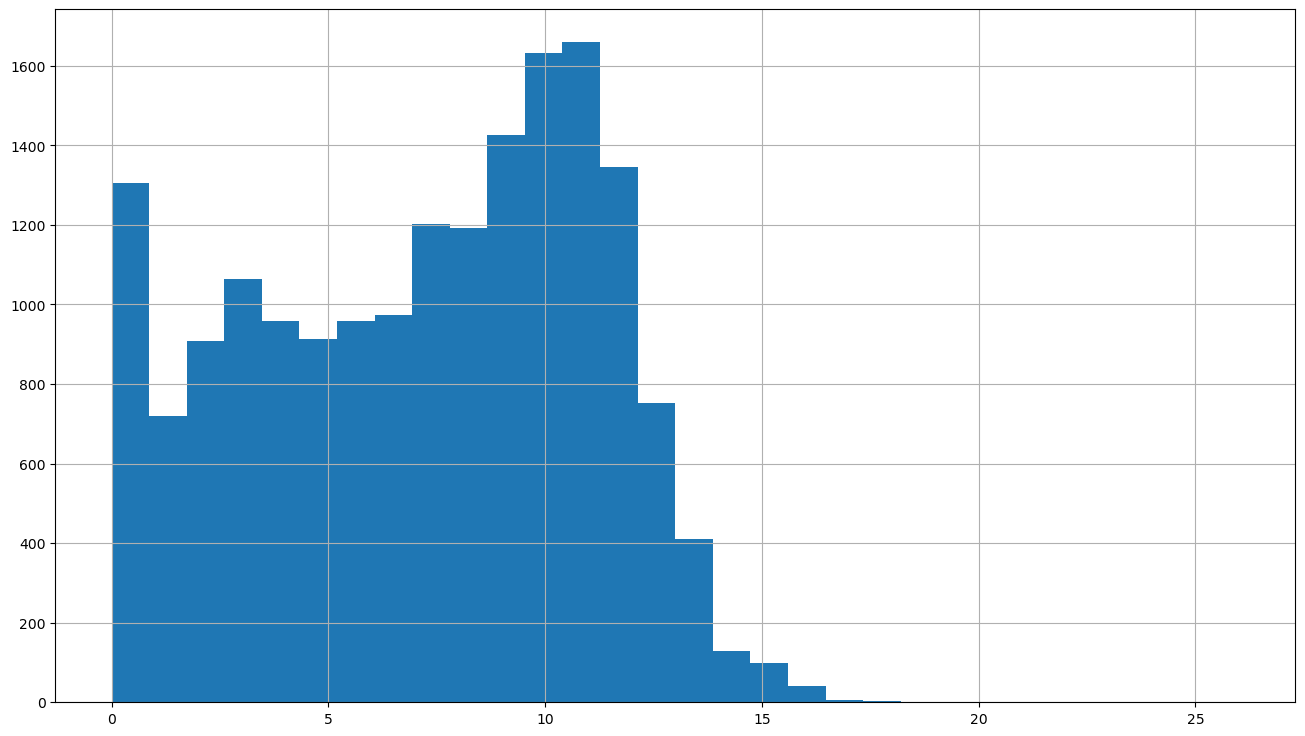

In [17]:
gold_full['secondary_cleaner.output.tail_sol'].hist(bins=30, figsize=(16,9));

In [18]:
gold_full['secondary_cleaner.output.tail_sol'].describe()

count    17691.000000
mean         7.167247
std          3.916079
min          0.000000
25%          3.845475
50%          7.685827
75%         10.411296
max         26.000772
Name: secondary_cleaner.output.tail_sol, dtype: float64

Из-за большого количества нулевых значений среднее смещено ближе к нулю, заполним пропуски медианными значениями

In [19]:
gold_full['secondary_cleaner.output.tail_sol'] = (
gold_full['secondary_cleaner.output.tail_sol'].fillna(gold_full['secondary_cleaner.output.tail_sol'].median()))

Распределение не похоже на "нормальное", есть много нулевых значений параметра 

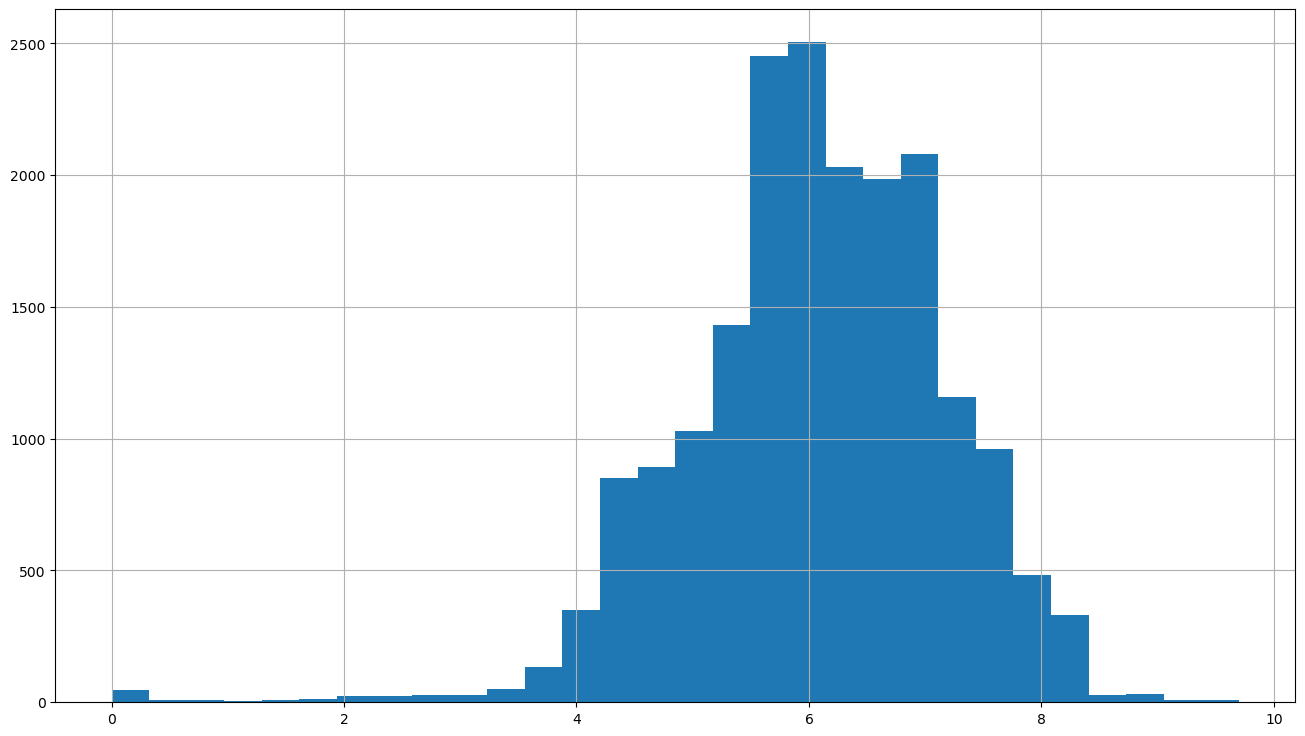

In [20]:
gold_full['rougher.input.floatbank11_xanthate'].hist(bins=30, figsize=(16,9));

In [21]:
gold_full['rougher.input.floatbank11_xanthate'] = (
gold_full['rougher.input.floatbank11_xanthate'].fillna(gold_full['rougher.input.floatbank11_xanthate'].mean()))

Распределение похоже на нормальное и пропуски можно заменить на средние значения

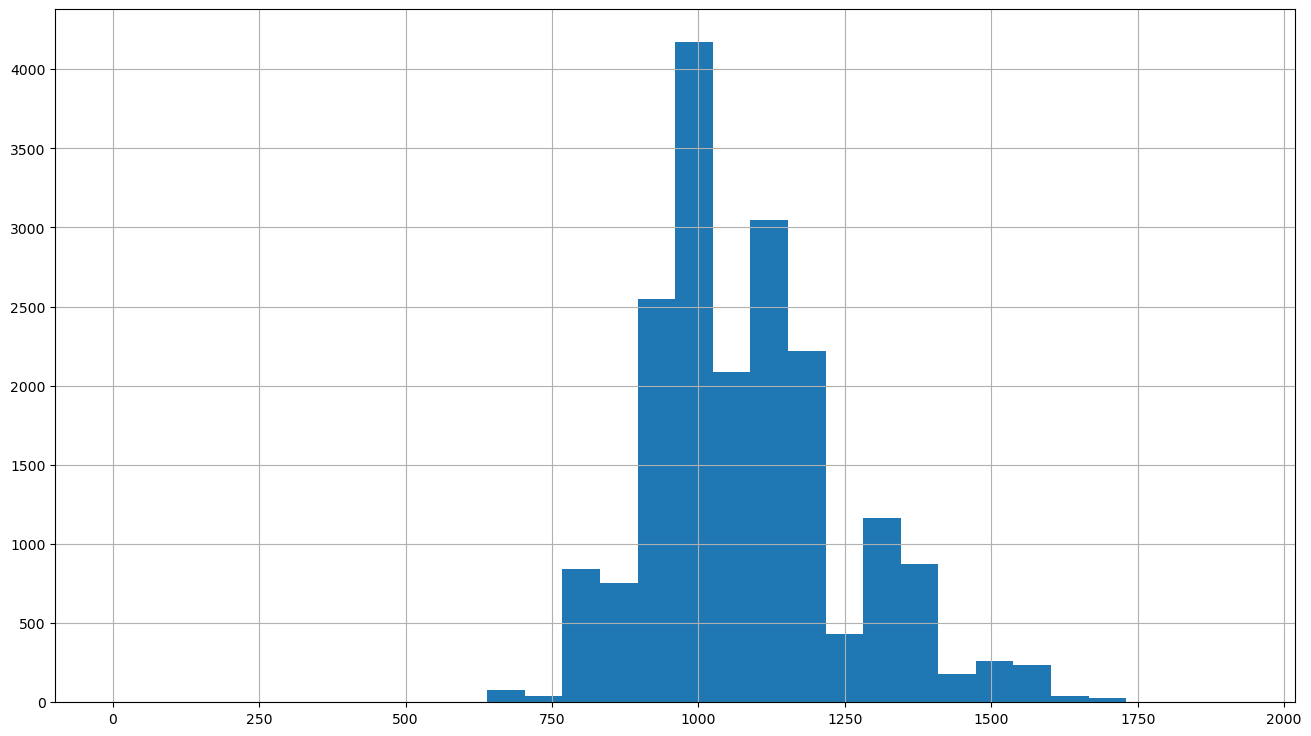

In [22]:
gold_full['rougher.state.floatbank10_e_air'].hist(bins=30, figsize=(16,9));

Распределение похоже на нормальное и пропуски можно заменить на средние значения

In [23]:
gold_full['rougher.state.floatbank10_e_air'] = (
gold_full['rougher.state.floatbank10_e_air'].fillna(gold_full['rougher.state.floatbank10_e_air'].mean()))

Проверим, сколько информации мы потеряем в случае удаления оставшихся строк с пропусками

In [24]:
gold_full.dropna().shape

(18164, 87)

Останется 18164 строки из исходных 19434, суммарные потери не превысят 7%, удалим строки с оставшимися пропущенными значениями.

In [25]:
gold_full = gold_full.dropna()

Создадим функцию для заполнения пропусков в обучающей и тестовой выборках

In [26]:
def filling(df):
    df['secondary_cleaner.output.tail_sol'] = (
    df['secondary_cleaner.output.tail_sol'].fillna(df['secondary_cleaner.output.tail_sol'].median()))
    df['rougher.input.floatbank11_xanthate'] = (
    df['rougher.input.floatbank11_xanthate'].fillna(df['rougher.input.floatbank11_xanthate'].mean()))
    df['rougher.state.floatbank10_e_air'] = (
    df['rougher.state.floatbank10_e_air'].fillna(df['rougher.state.floatbank10_e_air'].mean()))
    df = df.dropna()
    return df

In [27]:
gold_test = filling(gold_test)

In [28]:
gold_train = filling(gold_train)

**Проверим наличие выбросов и анамалий**

In [29]:
gold_full.describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,18164.0,5.160709,1.323115,0.000000e+00,4.250499,5.051770,5.875022,1.600195e+01
final.output.concentrate_pb,18164.0,10.021711,1.566978,0.000000e+00,9.158421,10.106536,11.043843,1.703190e+01
final.output.concentrate_sol,18164.0,9.614035,2.736866,0.000000e+00,7.853530,9.310806,11.018236,1.961572e+01
final.output.concentrate_au,18164.0,44.342318,4.336886,0.000000e+00,43.516822,45.055201,46.299552,5.157188e+01
final.output.recovery,18164.0,67.700800,8.803021,0.000000e+00,63.871619,68.459663,72.831400,1.000000e+02
final.output.tail_ag,18164.0,9.766414,2.301415,0.000000e+00,8.134250,9.820237,11.189927,1.955215e+01
final.output.tail_pb,18164.0,2.733293,0.939153,0.000000e+00,2.077418,2.770522,3.350265,5.804178e+00
final.output.tail_sol,18164.0,10.652980,2.732250,0.000000e+00,9.021832,10.646546,12.123213,2.227202e+01
final.output.tail_au,18164.0,3.059904,0.882567,0.000000e+00,2.480348,2.996648,3.575563,8.245022e+00
primary_cleaner.input.sulfate,18164.0,148.535291,41.986893,1.873963e+00,118.168364,146.396911,177.373312,2.659831e+02


**Проверим наличие дубликатов**

In [30]:
gold_full.duplicated().sum()

0

Преобразуем тип столбца `date` в datetime

In [31]:
gold_test['date'] = pd.to_datetime(gold_test['date'], format='%Y-%m-%d %H:%M:%S')

In [32]:
gold_train['date'] = pd.to_datetime(gold_full['date'], format='%Y-%m-%d %H:%M:%S')

In [33]:
gold_full['date'] = pd.to_datetime(gold_full['date'], format='%Y-%m-%d %H:%M:%S')

### Вывод

Имеются данные с параметрами добычи и очистки золотосодержащей руды\
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

**Признаки**\
признаки совпадают с параметрами таблицы `gold_test`\
**Целевые признаки**\
`rougher.output.recovery` — эффективность обогащения чернового концентрата\
`final.output.recovery` — эффективность обогащения финального концентрата\

1) Первый столбец всех таблиц имеет формат object, хотя содержит дату и время, его можно перевести в формат datetime (преобразовали)\
2) В таблице `gold_test` меньше столбцов, чем в остальных таблицах (53 вместо 87)\
3) В таблицах есть пропуски значений\
4) Значения в столбце `rougher.output.recovery` совпадают, что может свидетельствовать о том, что величина в столбце `rougher.output.recovery` рассчитывается по той же формуле, на основе данных в столбцах `rougher.output.concentrate_au`, `rougher.input.feed_au` и `rougher.output.tail_au`\
5) В тестовой выборке отсутствуют значения параметров продукта (выходные значения) для всех этапов технологического процесса (флотация, первичная очистка, вторичная очистка, финальные характеристики).\
6) В тестовой выборке нет параметров `feed`, необходимых для проверки размеров гранул сырья.\
7) Доля пропущенных значений не превышала 10% для параметра `secondary_cleaner.output.tail_sol`. Для 2 параметров `rougher.input.floatbank11_xanthate`  и `rougher.state.floatbank10_e_air` доля пропусков не более 3%,  доля пропусков в остальных параметрах не превышала 2%.\
8) Пропуски параметра `secondary_cleaner.output.tail_sol` были заполнены медианными значениями, пропуски параметров `rougher.input.floatbank11_xanthate`  и `rougher.state.floatbank10_e_air` были заполнены средними значениями, остальные пропуски были удалены (не более 7% от общего объема выборки).\
9) Дубликатов в данных не обнаружено\
10) Категориальных признаков не обнаружено

## Анализ данных

**Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки**

Напишем функцию для поиска концентраций металлов на разных стадиях технологического процесса

In [34]:
def concentrate (metal):
    df = gold_full.mean()
    calc = [col for col in gold_full.columns if metal in col]
    conc = [col for col in calc if 'calcul' not in col]
    return df[conc].sort_values()

Посмотрим, как меняется концентрация золота на различных этапах очистки

In [35]:
au = concentrate('au')
au

rougher.output.tail_au                    1.813808
final.output.tail_au                      3.059904
primary_cleaner.output.tail_au            3.886339
secondary_cleaner.output.tail_au          4.312568
rougher.input.feed_au                     8.395574
rougher.output.concentrate_au            19.832956
primary_cleaner.output.concentrate_au    32.117867
final.output.concentrate_au              44.342318
dtype: float64

Посмотрим, как меняется концентрация серебра на различных этапах очистки

In [36]:
ag = concentrate('ag')
ag 

final.output.concentrate_ag               5.160709
rougher.output.tail_ag                    5.606673
primary_cleaner.output.concentrate_ag     8.541476
rougher.input.feed_ag                     8.881569
final.output.tail_ag                      9.766414
rougher.output.concentrate_ag            12.036312
secondary_cleaner.output.tail_ag         14.656572
primary_cleaner.output.tail_ag           16.202679
dtype: float64

Посмотрим, как меняется концентрация свинца на различных этапах очистки

In [37]:
pb = concentrate('pb')
pb 

rougher.output.tail_pb                    0.644467
final.output.tail_pb                      2.733293
primary_cleaner.output.tail_pb            3.463051
rougher.input.feed_pb                     3.634480
secondary_cleaner.output.tail_pb          5.789204
rougher.output.concentrate_pb             7.607875
primary_cleaner.output.concentrate_pb     9.944044
final.output.concentrate_pb              10.021711
dtype: float64

1) Концентрация золота от этапа к этапу увеличивается с 8.4 в среднем, до 44.3. Концентрация золота в хвостах изменяется от 1.8 до 3.1 в среднем и в целом выглядит стабильно.

2) Концентрация серебра в основной массе изменяется от 8.9 до 5.2 и в целом выглядит стабильно. Концентрация серебра в хвостах увеличивается от 5.6 на начальных этапах до 14-16 в середине процесса и снижается до 9.8 на финальном этапе.

3) Концентрация свинца в основной массе увеличивается с 0.6 до 10 в среднем. Концентрация свинца в хвостах увеличивается от 0.6 на начальных этапах до 3-6 в середине процесса и снижается до 2.7 на финальном этапе.

**Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной**

Создадим функцию для поиска всех столбцов содержащих `feed_size`

In [38]:
def feed_size (df):
    df = df.mean()
    feed = [col for col in gold_full.columns if 'feed_size' in col]
    return df[feed].sort_values()

Проверим размеров гранул сырья на обучающей выборке

In [39]:
feed_size_train = feed_size(gold_train)

Проверим размеров гранул сырья на тестовой выборке

In [40]:
feed_size_test = feed_size(gold_test)
feed_size_test

primary_cleaner.input.feed_size     7.278842
rougher.input.feed_size            55.262457
dtype: float64

Посчитаем разницу между размерами гранул в обучающей и тестовой выборках

In [41]:
delta_feed_size = ((feed_size_train - feed_size_test) / feed_size_test ) * 100
delta_feed_size

primary_cleaner.input.feed_size    0.735587
rougher.input.feed_size            8.102835
dtype: float64

Размер гранул на этапе `rougher` для тестовой выборки на 8.1% больше, чем размер гранул на обучающей выборке. Для этапа `primary_cleaner` размер гранул на тестовой выборке на 0.7% больше, чем размер гранул на обучающей выборке. 

**Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах**

Создадим функцию для поиска всех столбцов содержащих концентрации веществ на всех стадия технологического процесса

In [42]:
def total_concentration(df):
    df = df.mean()
    concentration = [col for col in gold_full.columns if 'concen' in col]
    rougher = [col for col in concentration if 'rougher' in col]
    primary = [col for col in concentration if 'primary' in col]
    final = [col for col in concentration if 'final' in col]
    drop = df[rougher].drop('rougher.calculation.sulfate_to_au_concentrate') 
    print('Суммарная концентрация всех веществ на этапе сырья: ', round(drop.sum(), 2),'\n',
          'Cуммарная концентрация всех веществ на черновом этапе: ', round(df[primary].sum(), 2),'\n',  
          'Cуммарная концентрация всех веществ на финальном этапе: ', round(df[final].sum(), 2)) 

In [43]:
total_concentration(gold_full)

Суммарная концентрация всех веществ на этапе сырья:  68.41 
 Cуммарная концентрация всех веществ на черновом этапе:  61.16 
 Cуммарная концентрация всех веществ на финальном этапе:  69.14


Концентрации всех веществ находятся на уровне от 61 до 69, минимальное значение достигается на черновом этапе (61).

### Вывод

1) Концентрация золота от этапа к этапу увеличивается с 8.4 в среднем, до 44.3. Концентрация золота в хвостах изменяется от 1.8 до 3.1 в среднем и в целом выглядит стабильно.

2) Концентрация серебра в основной массе изменяется от 8.9 до 5.2 и в целом выглядит стабильно. Концентрация серебра в хвостах увеличивается от 5.6 на начальных этапах до 14-16 в середине процесса и снижается до 9.8 на финальном этапе.

3) Концентрация свинца в основной массе увеличивается с 0.6 до 10 в среднем. Концентрация свинца в хвостах увеличивается от 0.6 на начальных этапах до 3-6 в середине процесса и снижается до 2.7 на финальном этапе.

4) Размер гранул на этапе rougher для тестовой выборки на 8.1% больше, чем размер гранул на обучающей выборке. Для этапа primary_cleaner размер гранул на тестовой выборке на 0.7% больше, чем размер гранул на обучающей выборке.

5) Cуммарная концентрация всех веществ на этапе сырья:  68.41

6)  Cуммарная концентрация всех веществ на черновом этапе:  61.16

7) Cуммарная концентрация всех веществ на финальном этапе:  69.14

## Модель

Создадим функцию для вычисления итоговой sMAPE

In [44]:
def smape(target, predict):
    return 100/len(target) * np.sum(2 * np.abs(predict - target) / (np.abs(target) + np.abs(predict)))

Создадим метрику качества на основе нашей функции sMAPE

In [45]:
my_scorer = make_scorer(smape,  greater_is_better=False)

Создадим функцию для подсчета итоговой sMAPE

In [46]:
# sMAPE(rougher.output.recovery).25 + sMAPE(final.output.recovery).75
def full_smape(score_final, score_rougher):
    return score_rougher * .25 + score_final * .75

Разделим обучающую выборку на `features_train` и `target_train`

In [47]:
t = gold_train.drop(dif_tables, axis=1)
features_train = t.drop('date', axis=1)

In [48]:
target_train = gold_train['final.output.recovery']

Разделим тестовую выборку на `features_test` и `target_test`

In [49]:
t = gold_test.drop(dif_tables, axis=1)
features_test = t.drop('date', axis=1)

In [50]:
target_test = gold_test['final.output.recovery']

Выделим параметры для чернового концентрата 

In [51]:
def rougher(df):
    roug = [col for col in df.columns if 'rougher' in col]
    return df[roug]

Разделим обучающую выборку на `features_train` и `target_train` для  чернового концентрата

In [52]:
features_train_r = rougher(features_train)

In [53]:
target_train_r = gold_train['rougher.output.recovery']

Разделим тестовую выборку на `features_test` и `target_test` для чернового концентрата

In [54]:
features_test_r = rougher(features_test)

In [55]:
target_test_r = gold_test['rougher.output.recovery']

In [56]:
features_train_r.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128


Масштабируем признаки для обучения

In [57]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [58]:
features_train.shape

(13005, 52)

In [59]:
features_test.shape

(5159, 52)

In [60]:
features_test_r.shape

(5159, 22)

In [61]:
features_train_r.shape

(13005, 22)

Обучим модель линейной регрессии для расчета эффективности обогащения финального концентрата с учетом кросс валидации 

In [62]:
%%time
estimator = LinearRegression()
param_grid = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False], 
              'positive':[True, False]}
grid = GridSearchCV(estimator, param_grid, scoring=my_scorer, cv=5)
grid.fit(features_train, target_train)
predict = grid.best_estimator_.predict(features_test)
best_score_l = smape(target_test, predict)
print('Параметры лучшей модели: ', grid.best_params_)
print('sMAPE лучшей модели: ', best_score_l,'\n')

Параметры лучшей модели:  {'copy_X': True, 'fit_intercept': True, 'normalize': False, 'positive': True}
sMAPE лучшей модели:  8.054786407515374 

CPU times: user 24.6 s, sys: 731 ms, total: 25.3 s
Wall time: 3.4 s


Обучим модель Дерево решений для расчета эффективности обогащения финального концентрата с учетом кросс валидации 

In [63]:
%%time
estimator = DecisionTreeRegressor(random_state=42)
param_grid = {'max_depth': range(1,10,1)} 
grid = GridSearchCV(estimator, param_grid, scoring=my_scorer, cv=5)
grid = grid.fit(features_train, target_train)
best_score_t = smape(target_test, grid.best_estimator_.predict(features_test))
print('Параметры лучшей модели: ', grid.best_params_)
print('sMAPE лучшей модели: ', best_score_t,'\n')

Параметры лучшей модели:  {'max_depth': 4}
sMAPE лучшей модели:  9.308444810738909 

CPU times: user 14.1 s, sys: 185 ms, total: 14.3 s
Wall time: 12.8 s


Обучим модель Случайный лес для расчета эффективности обогащения финального концентрата с учетом кросс валидации 

In [64]:
%%time
estimator = RandomForestRegressor(random_state=42)
para_grids = {'n_estimators': range(60,100,10), 
              'max_depth': range(2,9,2)} 
grid = GridSearchCV(estimator, para_grids, cv=5)
grid = grid.fit(features_train, target_train)
best_score_f = smape(target_test, grid.best_estimator_.predict(features_test))
print('Параметры лучшей модели: ', grid.best_params_)
print('sMAPE лучшей модели: ', best_score_f,'\n')

Параметры лучшей модели:  {'max_depth': 4, 'n_estimators': 70}
sMAPE лучшей модели:  8.418650492333555 

CPU times: user 16min 52s, sys: 2.21 s, total: 16min 54s
Wall time: 16min 54s


Лучшие значения sMAPE показала модель линейной регрессии, так же это достаточно быстрая модель

Для дальнейших расчетов эффективности обогащения чернового концентрата будем использовать модель линейной регрессии

Обучим модель линейной регрессии для расчета эффективности обогащения чернового концентрата

In [65]:
%%time
estimator = LinearRegression()
param_grid = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False], 
              'positive':[True, False]}
grid = GridSearchCV(estimator, param_grid, scoring=my_scorer, cv=5)
grid.fit(features_train_r, target_train_r)
predict = grid.predict(features_test_r)
best_score_l_r = smape(target_test_r, predict)
print('Параметры лучшей модели: ', grid.best_params_)
print('sMAPE лучшей модели: ', best_score_l_r,'\n')

Параметры лучшей модели:  {'copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': True}
sMAPE лучшей модели:  8.371717902483791 

CPU times: user 11.1 s, sys: 335 ms, total: 11.5 s
Wall time: 1.56 s


Посчитаем итоговую метрику для линейной регресии

In [66]:
full_smape(best_score_l_r, best_score_l)

8.292485028741687

Проверим адекватность модели на DummyRegressor

DummyRegressor для финального концентрата

In [67]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
DummyRegressor()
predict = dummy_regr.predict(features_test)
dummy = smape(target_test_r, predict)
print('sMAPE Dummy модели: ', dummy)

sMAPE Dummy модели:  28.86935361168233


DummyRegressor для чернового концентрата

In [68]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_r, target_train_r)
DummyRegressor()
predict = dummy_regr.predict(features_test_r)
dummy_r = smape(target_test_r, predict)
print('sMAPE Dummy модели: ', dummy_r)

sMAPE Dummy модели:  9.85871699379236


Итоговый sMAPE для модели DummyRegressor

In [69]:
full_smape(dummy_r, dummy)

14.611376148264853

### Вывод

1) Создали функцию для вычисления sMAPE

2) Отмасштабировали признаки для обучения

3) Обучили 3 модели машинного обучения: Линейная регрессия, Решающее дерево и Случайный лес

4) Лучшие параметры для линейной регрессии :  {'copy_X': True, 'fit_intercept': True, 'normalize': False, 'positive': True} 
sMAPE лучшей модели:  8.05

5) Лучшие параметры для дерева решений:  {'max_depth': 4}
sMAPE лучшей модели:  9.30

6) Лучшие параметры для случайного леса:  {'max_depth': 4, 'n_estimators': 70}
sMAPE лучшей модели:  8.41

7) Лучшие параметры для линейной регрессии  в расчете эффективности обогащения чернового концентрата: 
{'copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': True}
sMAPE лучшей модели:  8.37

8) Итоговое значение sMAPE - 8.29, что практически в 2 раза лучше, чем модель DummyRegressor

## Общий вывод 

Имеются данные с параметрами добычи и очистки золотосодержащей руды

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Признаки:

признаки совпадают с параметрами таблицы `gold_test`

Целевые признаки:

`rougher.output.recovery` — эффективность обогащения чернового концентрата

`final.output.recovery` — эффективность обогащения финального концентрата

1) Первый столбец всех таблиц имеел формат object, хотя содержит дату и время, преобразовали его в формат datetime\
2) В таблице gold_test меньше столбцов, чем в остальных таблицах (53 вместо 87)\
3) В таблицах есть пропуски значений\
4) Значения в столбце `rougher.output.recovery` совпадают, что может свидетельствовать о том, что величина в столбце `rougher.output.recovery` раситывается по той же формуле, на основе данных в столбцах `rougher.output.concentrate_au`, `rougher.input.feed_au` и `rougher.output.tail_au`\
5) В тестовой выборке отсутствуют значения параметров продукта (выходные значения) для всех этапов технологического процесса (флотация, первичная очистка, вторичная очистка, финальные характеристики)\
6) В тестовой выборке нет параметров `feed`, необходимых для проверки размеров гранул сырья\
7) Доля пропущенных значений не превышала 10% для параметра `secondary_cleaner.output.tail_sol`. Для 2 параметров `rougher.input.floatbank11_xanthate` и `rougher.state.floatbank10_e_air` доля пропусков не более 3%, доля пропусков в остальных параметрах не превышала 2%\
8) Пропуски параметра `secondary_cleaner.output.tail_sol` были заполнены медианными значениями, пропуски параметров `rougher.input.floatbank11_xanthate` и `rougher.state.floatbank10_e_air` были заполнены средними значениями, остальные пропуски были удалены (не более 7% от общего объема выборки)\
9) Дубликатов в данных не обнаружено\
10) Категориальных признаков не обнаружено\
11) Концентрация золота от этапа к этапу увеличивается с 8.4 в среднем, до 44.3. Концентрация золота в хвостах изменяется от 1.8 до 3.1 в среднем и в целом выглядит стабильно\
12) Концентрация серебра в основной массе изменяется от 8.9 до 5.2 и в целом выглядит стабильно. Концентрация серебра в хвостах увеличивается от 5.6 на начальных этапах до 14-16 в середине процесса и снижается до 9.8 на финальном этапе\
13) Концентрация свинца в основной массе увеличивается с 0.6 до 10 в среднем. Концентрация свинца в хвостах увеличивается от 0.6 на начальных этапах до 3-6 в середине процесса и снижается до 2.7 на финальном этапе\
14) Размер гранул на этапе rougher для тестовой выборки на 8.1% больше, чем размер гранул на обучающей выборке. Для этапа primary_cleaner размер гранул на тестовой выборке на 0.7% больше, чем размер гранул на обучающей выборке\
15) Cуммарная концентрация всех веществ на этапе сырья: 68.41\
16) Cуммарная концентрация всех веществ на черновом этапе: 61.16\
17) Cуммарная концентрация всех веществ на финальном этапе: 69.14\
18) Создали функцию для вычисления sMAPE\
19) Отмасштабировали признаки для обучения\
20) Обучили 3 модели машинного обучения: Линейная регрессия, Решающее дерево и Случайный лес\
21) Лучшие параметры для линейной регрессии : {'copy_X': True, 'fit_intercept': True, 'normalize': False, 'positive': True} sMAPE лучшей модели: 8.05\
22) Лучшие параметры для дерева решений: {'max_depth': 4} sMAPE лучшей модели: 9.30\
23) Лучшие параметры для случайного леса: {'max_depth': 4, 'n_estimators': 70} sMAPE лучшей модели: 8.41\
24) Лучшие параметры для линейной регрессии в расчете эффективности обогащения чернового концентрата: {'copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': True} sMAPE лучшей модели: 8.37\
25) Итоговое значение sMAPE - 8.29, что практически в 2 раза лучше, чем модель DummyRegressor